In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
import logging
import numpy as np
import pandas as pd

assert os.getenv("PYCOX_DATA_DIR"), "env variable PYCOX_DATA_DIR must be set"

In [2]:
from pycox.datasets import kkbox_v1

kkbox_v1._path_dir.mkdir(exist_ok=True)

if not (kkbox_v1._path_dir / "cv_train_0.feather").exists():
    kkbox_v1._csv_to_feather_with_types()
    kkbox_v1._make_survival_data()
    kkbox_v1._make_survival_covariates()

### Preprocessing

In [3]:
covariates = pd.read_feather(kkbox_v1._path_dir / "covariates.feather")
covariates

,msno,event,n_prev_churns,days_between_subs,duration,days_since_reg_init,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,gender,registered_via,age_at_start,strange_age,nan_days_since_reg_init,no_prev_churns
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1.0,0.0,0.0,5.0,4549.0,7.0,0.0,0.0,0.0,0.0,15,female,9,28.0,0.0,0.0,1.0
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,1.0,0.0,0.0,410.0,1062.0,410.0,1788.0,1788.0,0.0,0.0,6,female,3,21.0,0.0,0.0,1.0
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.0,0.0,0.0,119.0,892.0,30.0,99.0,99.0,1.0,0.0,1,NaN,7,-0.0,1.0,0.0,1.0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1.0,0.0,0.0,413.0,1535.0,31.0,149.0,149.0,1.0,0.0,15,male,9,24.0,0.0,0.0,1.0
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.0,0.0,0.0,790.0,121.0,30.0,149.0,149.0,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646741,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,1.0,0.0,0.0,386.0,0.0,30.0,129.0,129.0,1.0,0.0,1,NaN,7,0.0,1.0,0.0,1.0
2646742,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,0.0,0.0,0.0,27.0,7.0,30.0,149.0,149.0,1.0,0.0,4,male,3,26.0,0.0,0.0,1.0
2646743,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,1.0,0.0,0.0,335.0,-1.0,30.0,99.0,99.0,1.0,0.0,NaN,NaN,NaN,-1.0,0.0,1.0,1.0
2646744,zzztsqkufVj9DPVJDM3FxDkhlbCL5z4aiYxgPSGkIK4=,1.0,0.0,0.0,7.0,125.0,7.0,0.0,0.0,0.0,0.0,1,female,3,30.0,0.0,0.0,1.0


In [4]:
def extra_cleaning(df):
    # remove id
    df.pop("msno")

    # ordinal encode gender
    df["gender"] = df["gender"].astype(str)
    gender_map = dict(zip(df["gender"].unique(), range(df["gender"].nunique())))
    df["gender"] = df["gender"].map(gender_map)
    
    # remove tricky np.nan in city, encoded as int
    df["city"] = df["city"].astype(str).replace("nan", -1).astype(int)
    
    # same for registered via
    df["registered_via"] = df["registered_via"].astype(str).replace("nan", -1).astype(int)
    
    return df

In [5]:
covariates = extra_cleaning(covariates)
covariates.isna().sum().sum()

0

In [6]:
from sksurv.datasets import get_x_y

X, y = get_x_y(covariates, ("event", "duration"), pos_label=1)

## RandomSurvivalForest

In [7]:
from time import perf_counter

from sksurv.metrics import (
    brier_score,
    integrated_brier_score,
    cumulative_dynamic_auc,
    concordance_index_censored,
    concordance_index_ipcw,
)

def get_scores_skurv(model, y_train, X_test, y_test, times):
    """Return the scores of scikit-survival models.
    
    - Brier scores
    - Integrated Brier scores (IBS)
    - C-index
    - C-index weighted
    
    This function is specific to scikit-survival because we require every evaluation
    to be performed of the same times values.
    """
    t0 = perf_counter()
    step_funcs = model.predict_survival_function(X_test, return_array=False)
    t1 = perf_counter()
    
    # Return_array=False gives us a list of step function, we call them with times
    # to generate survival probs at the chosen times.
    survival_probs = np.vstack([step_func(times) for step_func in step_funcs])
    
    # Return the risk estimate, a.k.a the sum of the cumulative hazard.
    # More accurate than using -np.log(survival_probs + 1e-8).sum()
    risk_estimate = model.predict(X_test)
    
    _, brier_scores = brier_score(y_train, y_test, survival_probs, times)
    ibs = integrated_brier_score(y_train, y_test, survival_probs, times)
    
    N_sample_c_index = 50_000
    c_index = concordance_index_censored(
        y_test["event"][:N_sample_c_index],
        y_test["duration"][:N_sample_c_index],
        risk_estimate[:N_sample_c_index],
    )[0]
    #c_index_ipcw = concordance_index_ipcw(
    #    y_train[:N_sample_c_index],
    #    y_test[:N_sample_c_index],
    #    risk_estimate[:N_sample_c_index],
    #)[0]
    
    return dict(
        times=times,
        brier_scores=brier_scores,
        ibs=ibs,
        c_index=c_index,
        #c_index_ipcw=c_index_ipcw,
        survival_probs=survival_probs,
        prediction_duration=t1 - t0,
    )

In [8]:
from models.utils import run_cv
from sksurv.ensemble import RandomSurvivalForest

rf_params = dict(
    max_leaf_nodes=100,
    min_samples_leaf=100,
    n_estimators=30,
    max_features=8,
    n_jobs=4,
)
rf = RandomSurvivalForest(**rf_params)

# only train on 100 * subsample % of the data for each fold
subsample_train = 0.01
subset = {"train": subsample_train, "val": subsample_train}

run_cv(
    X,
    y,
    rf,
    model_name="RandomSurvivalForest",
    score_func=get_scores_skurv,
    subset=subset,
)

train set: 21173, val set: 5293
train set: 21173, val set: 5293
train set: 21173, val set: 5293
train set: 21173, val set: 5293
train set: 21173, val set: 5293
ibs: 0.1106 ± 0.0009
c_index: 0.8349 ± 0.0050
training_duration: 31.5984 ± 3.3781
prediction_duration: 0.4326 ± 0.0644


## BiasedForestGridBC

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from models.tree_transformer import TreeTransformer
from models.meta_grid_bc import MetaGridBC
from models.utils import run_cv

rf_params = dict(
    min_samples_leaf=100,
    max_leaf_nodes=100,
    n_estimators=30,
    max_features=8,
    n_jobs=4,
    verbose=False,
)
lr_params = dict(
    C=1e-3, max_iter=500
)
forest_grid_bc = make_pipeline(
    TreeTransformer(
        RandomForestRegressor(**rf_params)
    ),  # ignores censoring
    MetaGridBC(
        LogisticRegression(**lr_params),
        verbose=False,
        n_jobs=4
    ),
)

run_cv(
    X,
    y,
    forest_grid_bc,
    model_name="BiasedForestGridBC",
    time_bins_kwargs={"metagridbc": "time_bins"}, # provide time_bins to fit 
)

train set: 2117396, val set: 529350
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
ibs: 0.1057 ± 0.0002
c_index: 0.8351 ± 0.0012
training_duration: 118.3577 ± 5.2893
prediction_duration: 7.3988 ± 0.4795


## XGBSE DebiasedBCE

In [10]:
from time import perf_counter

from sksurv.metrics import (
    brier_score,
    integrated_brier_score,
    cumulative_dynamic_auc,
    concordance_index_censored,
    concordance_index_ipcw,
)

def get_scores_xgbse(model, y_train, X_test, y_test, times):
    """Return the scores of XGBSE models.
    
    - Brier scores
    - Integrated Brier scores (IBS)
    - C-index
    - C-index weighted
    
    This function is specific to XGBSE because we use `predict()` to get
    survival probs.
    """    
    t0 = perf_counter()
    survival_probs = model.predict(X_test, return_interval_probs=False)
    t1 = perf_counter()
    
    risk_estimate = -np.log(survival_probs + 1e-8).sum(axis=1)
    
    _, brier_scores = brier_score(y_train, y_test, survival_probs, times)
    
    ibs = integrated_brier_score(y_train, y_test, survival_probs, times)
    
    N_sample_c_index = 50_000
    c_index = concordance_index_censored(
        y_test[:N_sample_c_index]["event"],
        y_test[:N_sample_c_index]["duration"],
        risk_estimate[:N_sample_c_index],
    )[0]
    
    #c_index_ipcw = concordance_index_ipcw(
    #    y_train[:N_sample_c_index],
    #    y_test[:N_sample_c_index],
    #    risk_estimate[:N_sample_c_index],
    #)[0]
    
    return dict(
        times=times,
        brier_scores=brier_scores,
        ibs=ibs,
        c_index=c_index,
        #c_index_ipcw=c_index_ipcw,
        survival_probs=survival_probs,
        prediction_duration=t1 - t0,
    )

In [11]:
from xgbse import XGBSEDebiasedBCE

from models.utils import run_cv

PARAMS_TREE_COX = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster': 'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0,
    'verbosity': 1,
    'nthread': 4,
}
xgbse_bce_cox = XGBSEDebiasedBCE(PARAMS_TREE_COX, n_jobs=4)

run_cv(
    X,
    y,
    xgbse_bce_cox,
    model_name="XGBSEDebiasedBCE",
    score_func=get_scores_xgbse,
    time_bins_kwargs={"_": "time_bins"},
    fit_kwargs={
        "num_boost_round": 30,  # instead of 1000
        "verbose_eval": 5,  # print eval every 5 rounds
    },
)

train set: 2117396, val set: 529350
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
ibs: 0.1063 ± 0.0003
c_index: 0.8361 ± 0.0005
training_duration: 158.6818 ± 20.7506
prediction_duration: 10.2579 ± 1.4376


## BiasedKaplanTree

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

from models.kaplan_tree import KaplanTree
from models.tree_transformer import TreeTransformer
from models.utils import run_cv

tree_params = dict(
    min_samples_leaf=100,
    max_leaf_nodes=100,
)

biased_kaplan_tree = make_pipeline(
    TreeTransformer(
        DecisionTreeRegressor(**tree_params),
    ),
    KaplanTree(),
)

run_cv(
    X,
    y,
    biased_kaplan_tree,
    model_name="BiasedKaplanTree",
    time_bins_kwargs={"kaplantree": "time_bins"},  # provide time_bins to fit 
)

train set: 2117396, val set: 529350
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
ibs: 0.1073 ± 0.0002
c_index: 0.8177 ± 0.0009
training_duration: 22.5636 ± 0.1713
prediction_duration: 3.9355 ± 0.0756


## XGBSE KaplanTree

In [13]:
from xgbse._kaplan_neighbors import XGBSEKaplanTree

from models.utils import run_cv

PARAMS_TREE_COX = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist',
    'max_depth': 10,
    'booster': 'dart',
    'subsample': 1.0,
    'min_child_weight': 50,
    'colsample_bynode': 1.0,
    'verbosity': 1,
    'nthread': 4,
}
xgbse_kaplan_tree = XGBSEKaplanTree(PARAMS_TREE_COX)

run_cv(
    X,
    y,
    xgbse_kaplan_tree,
    score_func=get_scores_xgbse,
    model_name="XGBSEKaplanTree",
    fit_kwargs={"persist_train": False},  # don't build a BallTree and don't keep index
    time_bins_kwargs={"_": "time_bins"},  # pass dynamic time_bins to fit
)

train set: 2117396, val set: 529350
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
train set: 2117397, val set: 529349
ibs: 0.1078 ± 0.0003
c_index: 0.8116 ± 0.0018
training_duration: 321.1111 ± 18.8548
prediction_duration: 1.7714 ± 0.0320


## PyCox DeepHitSingle

Single = No competing risks.

***Define the model***

In [14]:
import torchtuples as tt
from torch import optim

from pycox.models.deephit import DeepHitSingle

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold

from models.utils import run_cv

num_durations = 100  # PyCox default is 10

# `label_transform` is used to bin duration into `num_durations` chunks.
# Bins can be inspected via `labtrans.cuts`.
# 
# We `fit_transform` the whole `y` instead of `fit_transform` on `y_train`
# then `transform` on `y_val` because there is no actual learning during the `fit`
# and therefore no risk of leakage.
#
# `y_pycox` is the tuple (idx_duration, event)
labtrans = DeepHitSingle.label_transform(num_durations)
y_pycox = labtrans.fit_transform(y["duration"], y["event"])

# PyCox require covariates to be 32bits
X_pycox = X.copy().astype(np.float32)

# We also define the underlying net of the DeepHit model.
net = tt.practical.MLPVanilla(
    in_features=X.shape[1],
    num_nodes=[32, 32],
    out_features=num_durations,
    batch_norm=True,
    dropout=0.1,
)

deephit_single = DeepHitSingle(
    net,
    optim.Adam,
    alpha=0.2,
    sigma=0.1,
    duration_index=labtrans.cuts
)
deephit_single.optimizer.set_lr(0.01) # PyCox default

# PyCox uses `StandardScaler` on specific columns, we mimic it by normalizing
# on large numeric columns.
num_cols = [
    "days_between_subs",
    "days_since_reg_init",
    "payment_plan_days",
    "plan_list_price",
    "actual_amount_paid",
    "age_at_start",
]
cols = X.columns
col_to_idx = dict(zip(cols, range(len(cols))))
idx_cols = [col_to_idx[col] for col in num_cols]

preprocessing = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), idx_cols)
], remainder="passthrough")

model = make_pipeline(
    preprocessing,
    deephit_single,
)

fit_kwargs = dict(
    deephitsingle__batch_size=256,
    deephitsingle__epochs=20,
)

***fit***

In [15]:
from time import perf_counter

N = X.shape[0]
n_train = N * .8
n_val = N - n_train

# no subsetting
train_subset, val_subset = 1., 1.
n_sample_train = int(train_subset * n_train)
n_sample_val = int(val_subset * n_val)

train_slice = slice(0, n_sample_train)
val_slice = slice(n_sample_train, n_sample_train+n_sample_val)

y_train = (
    y_pycox[0][train_slice],
    y_pycox[1][train_slice],
)
y_val = (
    y_pycox[0][val_slice],
    y_pycox[1][val_slice],
)

X_train = X_pycox.values[train_slice]
X_val = X_pycox.values[val_slice]

print(f"train set: {len(X_train)}, val set: {len(X_val)}")

t0 = perf_counter()
model.fit(X_train, y_train, **fit_kwargs)
training_duration = perf_counter() - t0

train set: 2117396, val set: 529349
0:	[38s / 38s],		train_loss: 0.5559
1:	[38s / 1m:16s],		train_loss: 0.5415
2:	[38s / 1m:55s],		train_loss: 0.5388
3:	[38s / 2m:34s],		train_loss: 0.5371
4:	[38s / 3m:12s],		train_loss: 0.5364
5:	[38s / 3m:51s],		train_loss: 0.5353
6:	[38s / 4m:30s],		train_loss: 0.5349
7:	[38s / 5m:8s],		train_loss: 0.5342
8:	[38s / 5m:47s],		train_loss: 0.5341
9:	[38s / 6m:26s],		train_loss: 0.5329
10:	[39s / 7m:5s],		train_loss: 0.5322
11:	[37s / 7m:43s],		train_loss: 0.5316
12:	[35s / 8m:18s],		train_loss: 0.5310
13:	[38s / 8m:57s],		train_loss: 0.5304
14:	[39s / 9m:36s],		train_loss: 0.5312
15:	[38s / 10m:15s],		train_loss: 0.5300
16:	[38s / 10m:54s],		train_loss: 0.5307
17:	[38s / 11m:33s],		train_loss: 0.5302
18:	[37s / 12m:10s],		train_loss: 0.5299
19:	[38s / 12m:48s],		train_loss: 0.5298


***compute score***

In [16]:
from time import perf_counter

from sksurv.metrics import (
    brier_score,
    integrated_brier_score,
    cumulative_dynamic_auc,
    concordance_index_censored,
    concordance_index_ipcw,
)
from sksurv.util import Surv


def get_pycox_scores(estimator, y_train, X_test, y_test, times):
    """Return the scores of PyCox models.
    
    - Brier scores
    - IBS
    - C-index
    - C-index weighted
    
    This function is specific to PyCox because we use predict_surv
    to get a DataFrame of survival probs.
    """
    t0 = perf_counter()
    
    # StandardScaler()
    X_test_trans = estimator[0].transform(X_test)
    
    # DeepHitModel
    survival_probs = estimator[1].predict_surv_df(X_test_trans)
    time_index = np.asarray(survival_probs.index)
    survival_probs = survival_probs.reset_index(drop=True).T
    survival_probs.columns = time_index
    
    t1 = perf_counter()
    
    risk_estimate = -np.log(survival_probs + 1e-8).sum(axis=1)

    # y format: from PyCox to scikit-survival
    # We test all models with scikit-survival score functions for exactness.
    y_train_array = Surv.from_arrays(
        time=y_train[0],
        event=y_train[1],
        name_time="duration",
        name_event="event",
    )
    y_test_array = Surv.from_arrays(
        time=y_test[0],
        event=y_test[1],
        name_time="duration",
        name_event="event",
    )

    _, brier_scores = brier_score(y_train_array, y_test_array, survival_probs, times)
    ibs = integrated_brier_score(y_train_array, y_test_array, survival_probs, times)
    
    # Downsample the scoring dataset to avoid computing issues
    N_sample_c_index = 50_000
    c_index = concordance_index_censored(
        y_test_array[:N_sample_c_index]["event"],
        y_test_array[:N_sample_c_index]["duration"],
        risk_estimate[:N_sample_c_index],
    )[0]

    # Weird error in sksruv CensoringDistributionEstimator.predict_ipcw()
    # when at least one element of Ghat equals zero.
    # We only have this error with PyCox.
    #try:
    #    c_index_ipcw = concordance_index_ipcw(
    #        y_train_array[:N_sample_c_index],
    #        y_test_array[:N_sample_c_index],
    #        risk_estimate[:N_sample_c_index],
    #    )[0]
    #except ValueError:
    #    c_index_ipcw = None
        
    return dict(
        times=time_index,
        brier_scores=brier_scores,
        ibs=ibs,
        c_index=c_index,
        #c_index_ipcw=c_index_ipcw,
        survival_probs=survival_probs,
        prediction_duration=t1 - t0,
    )

In [17]:
from models.utils import save_scores

times_pycox = np.linspace(0, 98, 100)

scores = get_pycox_scores(model, y_train, X_val, y_val, times_pycox)
scores["training_duration"] = training_duration

# Since we're not cross validating DeepHit, we still got to
# respect the score object signature by passing list.
for col in ["times", "brier_scores", "survival_probs"]:
    scores[col] = [scores[col]]

score_keys = [
    "ibs",
    "c_index",
    #"c_index_ipcw",
    "training_duration",
    "prediction_duration",
]
for k in score_keys:
    values = scores.pop(k)
    k_mean, k_std = f"mean_{k}", f"std_{k}"
    scores[k_mean] = np.mean(values)
    scores[k_std] = np.std(values)
    print(f"{k}: {scores[k_mean]:.4f} ± {scores[k_std]:.4f}")
scores["n_sample_train"] = len(X_train)
scores["n_sample_val"] = len(X_val)

filename = "cv_DeepHitSingle"
save_scores(filename, scores)

ibs: 0.1543 ± 0.0000
c_index: 0.7822 ± 0.0000
training_duration: 769.8636 ± 0.0000
prediction_duration: 1.3517 ± 0.0000


# Results

In [18]:
from models.utils import get_all_results

df_tables, df_lines = get_all_results(match_filter="cv_")

In [19]:
df_tables

,Method,C_td,IBS,training_duration,prediction_duration,n_sample_train,n_sample_val
0,BiasedForestGridBC,0.8352 ± 0.0017,0.1055 ± 0.0003,119.4900s,7.3213s,2117397,529349
1,BiasedKaplanTree,0.8251 ± 0.0023,0.1063 ± 0.0002,20.1045s,3.6972s,2117397,529349
2,XGBSEDebiasedBCE,0.8365 ± 0.0022,0.1063 ± 0.0003,153.2796s,9.2849s,2117397,529349
3,XGBSEKaplanTree,0.8229 ± 0.0029,0.1065 ± 0.0003,261.7722s,1.6475s,2117397,529349
4,RandomSurvivalForest,0.8341 ± 0.0059,0.1109 ± 0.0004,30.0169s,0.4672s,21173,5293
5,DeepHitSingle,0.7822 ± 0.0000,0.1543 ± 0.0000,769.8636s,1.3517s,2117396,529349


Methods from the [PyCox paper](https://jmlr.org/papers/volume20/18-424/18-424.pdf) obtained the following results with the same preprocessing:

<img src="../data/kkbox/kkbox_v1/pycox_paper_table7.png" alt="pycox-table7" style="width: 400px;"/>

Our DeepHit benchmark yields a poorer C-index than reported by PyCox. The IBS is close, however.

In [20]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

mpl.rcParams['figure.dpi'] = 150
sns.set_theme()
sns.set_context("paper")


def plot_brier_scores(df_lines):

    cols = df_lines.columns
    col_to_idx = dict(zip(cols, range(len(cols))))
    
    fig, ax = plt.subplots(figsize=(14, 5))
    for row in df_lines.values:
        ax.plot(
            row[col_to_idx["times"]],
            row[col_to_idx["brier_scores"]],
            label=row[col_to_idx["model"]],
        )
    plt.ylim([0, .225])
    plt.xlabel("Duration (days)")
    plt.ylabel("Brier score")
    legend = plt.legend(
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=0,
        ncol=6,
        facecolor='white',
    );
    frame = legend.get_frame()
    frame.set_linewidth(2)

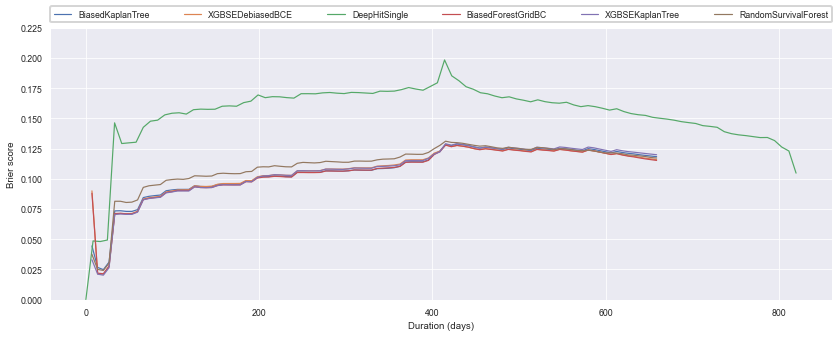

In [21]:
plot_brier_scores(df_lines)

Brier scores from the [PyCox paper](https://jmlr.org/papers/volume20/18-424/18-424.pdf) obtained the following results with the same preprocessing:

<img src="../data/kkbox/kkbox_v1/pycox_paper_figure4.png" alt="pycox-table7" style="width: 900px;"/>

### Individual predictions

In [22]:
def plot_individuals_survival_curve(df_lines, n_indiv=5):

    df_lines.sort_values("model", inplace=True)

    fig, axes = plt.subplots(nrows=df_lines.shape[0], ncols=1, figsize=(10, 15), constrained_layout=True)

    cols = df_lines.columns
    col_to_idx = dict(zip(cols, range(len(cols))))

    max_indiv_id = min([len(el) for el in df_lines["survival_probs"].values])
    idxs_indiv = np.random.uniform(high=max_indiv_id, size=n_indiv).astype(int)

    for idx, row in enumerate(df_lines.values):
        for jdx in idxs_indiv:
            axes[idx].plot(
                row[col_to_idx["times"]],
                row[col_to_idx["survival_probs"]][jdx, :]
            )
        axes[idx].set_title(row[col_to_idx["model"]])

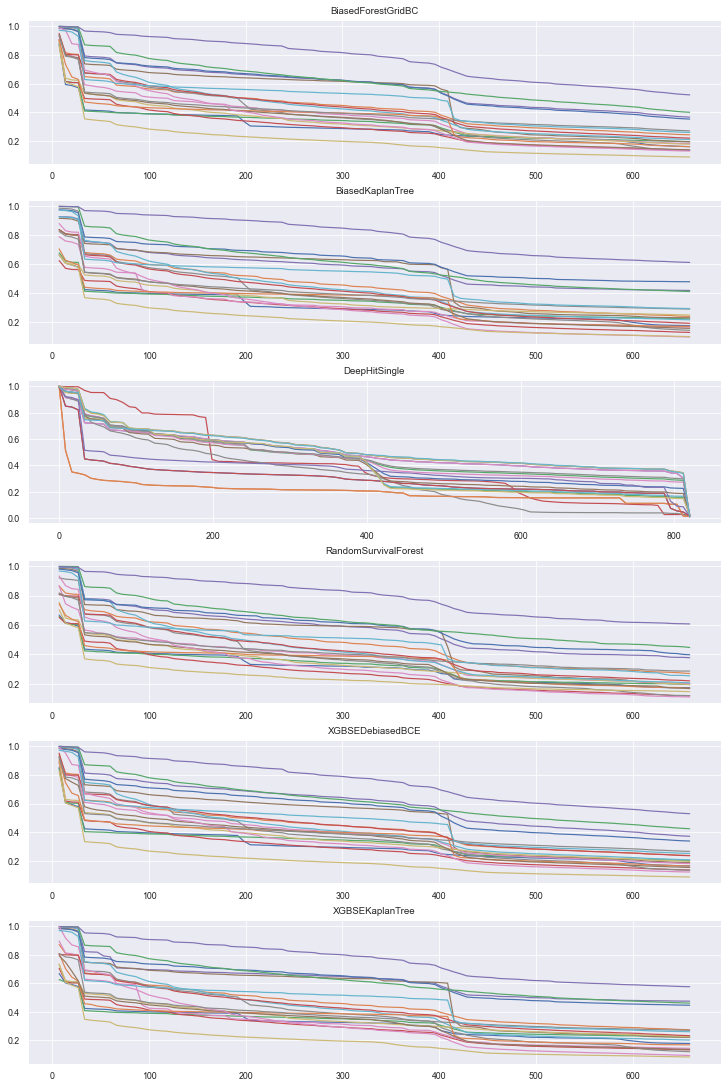

In [23]:
plot_individuals_survival_curve(df_lines, n_indiv=20)